In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torchvision import transforms, models

# --- CONFIGURATION ---
BATCH_SIZE = 64
IMG_SIZE = 128
LEARNING_RATE = 1e-4
EPOCHS = 15
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"⚙️ Configuration : {DEVICE} | Batch: {BATCH_SIZE} | Img: {IMG_SIZE}")

⚙️ Configuration : cuda | Batch: 64 | Img: 128


In [2]:
# --- TRANSFORMATIONS (Augmentation) ---
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# --- DATASET  ---
class UniversalAutoViDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []       
        self.part_names = []   
        self.stratify_labels = [] 

        print(f" Scan de {root_dir}...")
        
        seen_filenames = set()

        for root, dirs, files in os.walk(root_dir):
            png_files = [f for f in files if f.lower().endswith('.png')]
            
            if png_files:
                path_parts = root.split(os.sep)
                
                part_name = "unknown"
                if 'train' in path_parts:
                    idx = path_parts.index('train')
                    part_name = path_parts[idx-1]
                elif 'test' in path_parts:
                    idx = path_parts.index('test')
                    part_name = path_parts[idx-1]
                else:
                    continue 

                if part_name in ['ground_truth', 'images']: continue

                for file in png_files:
                    unique_id = f"{part_name}/{file}"
                    if unique_id in seen_filenames:
                        continue
                    seen_filenames.add(unique_id)

                    full_path = os.path.join(root, file)
                    
                    label = 0 if 'good' in path_parts else 1

                    self.image_paths.append(full_path)
                    self.labels.append(label)
                    self.part_names.append(part_name)
                    self.stratify_labels.append(f"{part_name}_{label}")

        unique_parts = sorted(list(set(self.part_names)))
        print(f" Total images chargées : {len(self.image_paths)}")
        print(f" Pièces détectées ({len(unique_parts)}) : {unique_parts}")
        
        if len(self.image_paths) == 0:
            raise ValueError(" Aucune image trouvée ! Vérifiez /kaggle/input")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            image = Image.open(self.image_paths[idx]).convert('RGB')
        except:
            return torch.zeros((3, IMG_SIZE, IMG_SIZE)), torch.tensor(0), "error"

        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(self.labels[idx], dtype=torch.long), self.part_names[idx]

# --- INITIALISATION ---
DATA_ROOT = "/kaggle/input" # Racine Kaggle

try:
    full_dataset = UniversalAutoViDataset(DATA_ROOT, transform=None)

    train_idx, test_idx = train_test_split(
        list(range(len(full_dataset))),
        test_size=0.2,
        stratify=full_dataset.stratify_labels, 
        random_state=42
    )

    # Loaders
    train_set = UniversalAutoViDataset(DATA_ROOT, transform=train_transform)
    test_set = UniversalAutoViDataset(DATA_ROOT, transform=test_transform)

    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler(train_idx))
    test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler(test_idx))
    
    print(f" Dataloaders prêts ! Train: {len(train_idx)} | Test: {len(test_idx)}")

except Exception as e:
    print(f" Erreur critique : {e}")

🔄 Scan intelligent de /kaggle/input...
✅ Total images chargées : 1352
🧩 Pièces détectées (5) : ['engine_wiring', 'pipe_clip', 'tank_screw', 'underbody_pipes', 'underbody_screw']
🔄 Scan intelligent de /kaggle/input...
✅ Total images chargées : 1352
🧩 Pièces détectées (5) : ['engine_wiring', 'pipe_clip', 'tank_screw', 'underbody_pipes', 'underbody_screw']
🔄 Scan intelligent de /kaggle/input...
✅ Total images chargées : 1352
🧩 Pièces détectées (5) : ['engine_wiring', 'pipe_clip', 'tank_screw', 'underbody_pipes', 'underbody_screw']
🚀 Dataloaders prêts ! Train: 1081 | Test: 271


In [3]:
class ExpertResNet(nn.Module):
    def __init__(self):
        super(ExpertResNet, self).__init__()
        self.net = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        
        num_features = self.net.fc.in_features
        self.net.fc = nn.Linear(num_features, 2)
        
    def forward(self, x):
        return self.net(x)
    
    def get_last_conv_layer(self):
        return self.net.layer4[-1]

model = ExpertResNet().to(DEVICE)
print("✅ Modèle ResNet18 chargé.")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:01<00:00, 26.7MB/s]


✅ Modèle ResNet18 chargé.


In [4]:
train_labels = [full_dataset.labels[i] for i in train_idx]
n_good = train_labels.count(0)
n_defect = train_labels.count(1)
weight = n_good / n_defect if n_defect > 0 else 1.0

print(f"⚖️ Balance Train -> Good: {n_good}, Defect: {n_defect} (Poids: {weight:.2f})")
class_weights = torch.tensor([1.0, weight]).to(DEVICE)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

def train_loop():
    train_losses = []
    
    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        
        for images, labels, _ in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels, _ in test_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        avg_train_loss = running_loss / len(train_loader)
        avg_val_loss = val_loss / len(test_loader)
        acc = 100 * correct / total
        train_losses.append(avg_train_loss)
        
        lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Acc: {acc:.2f}% | LR: {lr:.1e}")
        
        scheduler.step(avg_val_loss)
        
    return train_losses

history = train_loop()
torch.save(model.state_dict(), "resnet_autovi_final.pth")
print("💾 Modèle sauvegardé.")

⚖️ Balance Train -> Good: 976, Defect: 105 (Poids: 9.30)
Epoch 1/15 | Train Loss: 0.6428 | Val Loss: 0.3103 | Acc: 76.75% | LR: 1.0e-04
Epoch 2/15 | Train Loss: 0.3245 | Val Loss: 0.1808 | Acc: 96.31% | LR: 1.0e-04
Epoch 3/15 | Train Loss: 0.1586 | Val Loss: 0.1854 | Acc: 98.89% | LR: 1.0e-04
Epoch 4/15 | Train Loss: 0.0832 | Val Loss: 0.2263 | Acc: 93.73% | LR: 1.0e-04
Epoch 5/15 | Train Loss: 0.0905 | Val Loss: 0.1164 | Acc: 98.89% | LR: 1.0e-04
Epoch 6/15 | Train Loss: 0.0935 | Val Loss: 0.1119 | Acc: 99.26% | LR: 1.0e-04
Epoch 7/15 | Train Loss: 0.0441 | Val Loss: 0.0652 | Acc: 99.63% | LR: 1.0e-04
Epoch 8/15 | Train Loss: 0.0296 | Val Loss: 0.0544 | Acc: 99.63% | LR: 1.0e-04
Epoch 9/15 | Train Loss: 0.0260 | Val Loss: 0.0821 | Acc: 99.63% | LR: 1.0e-04
Epoch 10/15 | Train Loss: 0.0138 | Val Loss: 0.1296 | Acc: 98.89% | LR: 1.0e-04
Epoch 11/15 | Train Loss: 0.0176 | Val Loss: 0.0678 | Acc: 99.63% | LR: 1.0e-04
Epoch 12/15 | Train Loss: 0.0129 | Val Loss: 0.0702 | Acc: 99.63% | LR: 

🔍 Analyse détaillée...


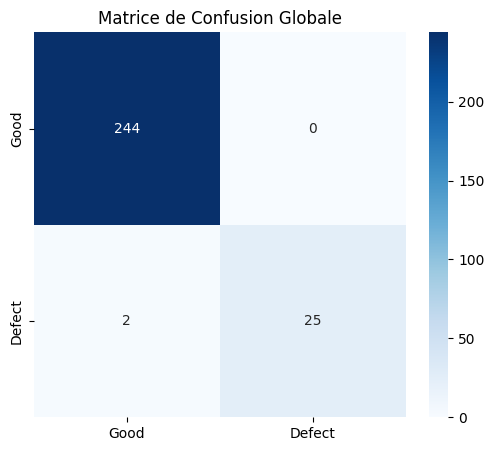


--- 📊 Précision par Type de Pièce ---
Pièce                | Total  | Précision
---------------------------------------------
engine_wiring        | 57     | 100.00%
pipe_clip            | 39     | 100.00%
tank_screw           | 64     | 100.00%
underbody_pipes      | 36     | 97.22%
underbody_screw      | 75     | 98.67%


In [5]:
def evaluate_by_part(model, loader):
    model.eval()
    
    y_true = []
    y_pred = []
    y_parts = []
    
    with torch.no_grad():
        for images, labels, parts in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_parts.extend(parts)
            
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Good', 'Defect'], yticklabels=['Good', 'Defect'])
    plt.title('Matrice de Confusion Globale')
    plt.show()
    
    print("\n--- 📊 Précision par Type de Pièce ---")
    print(f"{'Pièce':<20} | {'Total':<6} | {'Précision':<8}")
    print("-" * 45)
    
    unique_parts = sorted(list(set(y_parts)))
    for part in unique_parts:
        indices = [i for i, p in enumerate(y_parts) if p == part]
        
        part_true = [y_true[i] for i in indices]
        part_pred = [y_pred[i] for i in indices]
        
        if len(indices) > 0:
            correct = sum([1 for t, p in zip(part_true, part_pred) if t == p])
            acc = 100 * correct / len(indices)
            print(f"{part:<20} | {len(indices):<6} | {acc:.2f}%")

print("🔍 Analyse détaillée...")
evaluate_by_part(model, test_loader)

📸 Visualisation d'un défaut aléatoire...


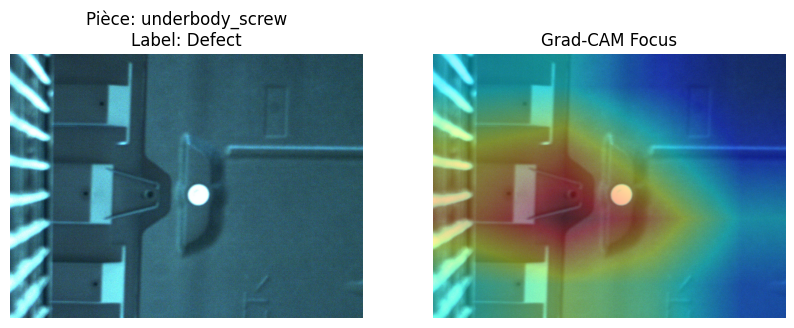

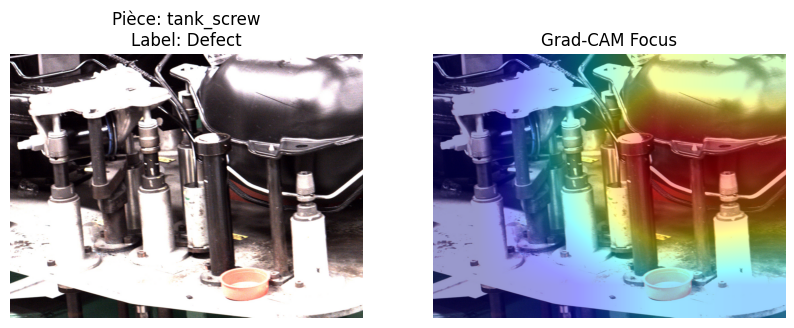

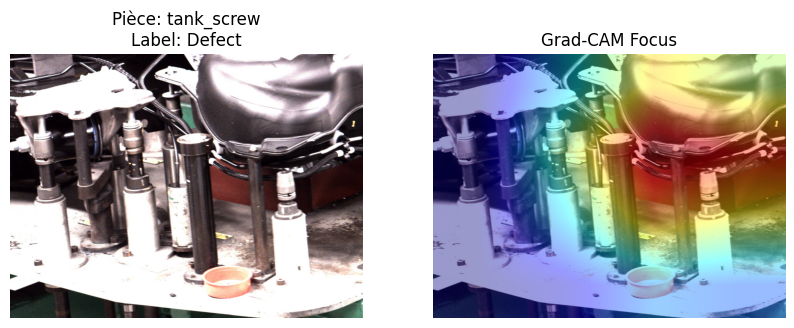

In [7]:
# --- CLASSE GRAD-CAM ---
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x, class_idx=None):
        output = self.model(x)
        if class_idx is None:
            class_idx = torch.argmax(output)
            
        self.model.zero_grad()
        score = output[0, class_idx]
        score.backward()
        
        gradients = self.gradients[0]
        pooled_gradients = torch.mean(gradients, dim=[1, 2])
        activations = self.activations[0]
        
        for i in range(activations.shape[0]):
            activations[i, :, :] *= pooled_gradients[i]
            
        heatmap = torch.mean(activations, dim=0).cpu().detach().numpy()
        heatmap = np.maximum(heatmap, 0)
        if np.max(heatmap) != 0:
            heatmap /= np.max(heatmap)
        return heatmap

def show_cam(model, dataset, idx):

    img_pil, lbl, part_name = dataset[idx]
    
    input_tensor = test_transform(img_pil).unsqueeze(0).to(DEVICE)
    
    target_layer = model.get_last_conv_layer()
    grad_cam = GradCAM(model, target_layer)
    
    heatmap = grad_cam(input_tensor, class_idx=1)
    
    plt.figure(figsize=(10, 4))
    
    img_disp = np.array(img_pil) 
    
    plt.subplot(1, 2, 1)
    plt.imshow(img_disp)
    plt.title(f"Pièce: {part_name}\nLabel: {'Defect' if lbl==1 else 'Good'}")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    heatmap = cv2.resize(heatmap, (img_disp.shape[1], img_disp.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    
    superimposed = cv2.addWeighted(img_disp, 0.6, heatmap, 0.4, 0)
    
    plt.imshow(superimposed)
    plt.title("Grad-CAM Focus")
    plt.axis('off')
    plt.show()

# --- TEST ---
print("📸 Visualisation d'un défaut aléatoire...")
defect_indices = [i for i, x in enumerate(full_dataset.labels) if x == 1]

if defect_indices:
    import random
    for _ in range(3):
        idx = random.choice(defect_indices)
        show_cam(model, full_dataset, idx)
else:
    print("Aucun défaut trouvé dans le dataset.")

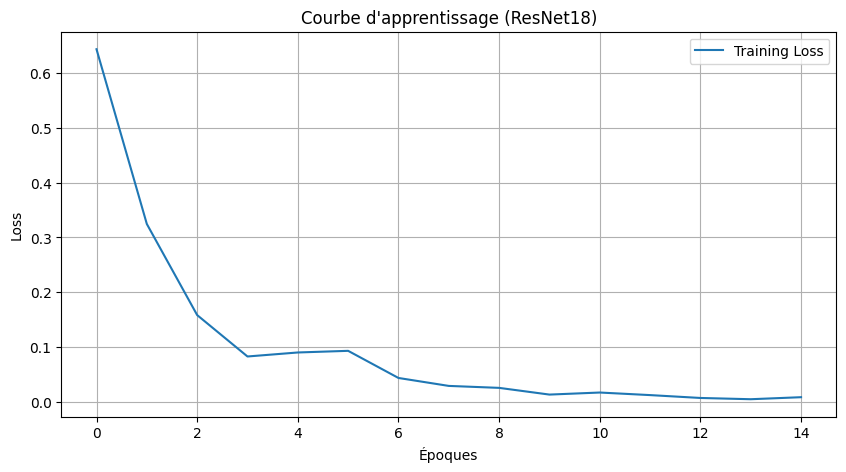

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(history, label='Training Loss')
plt.title('Courbe d\'apprentissage (ResNet18)')
plt.xlabel('Époques')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()